In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import (
    accuracy_score, confusion_matrix,
    classification_report, roc_auc_score,
    roc_curve, precision_recall_curve
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline


sns.set(style="whitegrid", font_scale=1.2)


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DOS_Project/data_cleaned/Final_cleaned_dataset.csv')
print("Shape:", df.shape)
df.head()


Shape: (1002478, 79)


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,88,609,7,4,484,414,233,0,69.142857,111.967895,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
1,88,879,9,4,656,3064,313,0,72.888889,136.153814,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
2,88,1160,9,6,3134,3048,1552,0,348.222222,682.482560,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
3,88,524,7,4,2812,2820,1397,0,401.714286,679.914876,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
4,1034,6,1,1,6,6,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0


CHECK CLASS DISTIBUTION


/tmp/ipython-input-1522395137.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["Label"], palette="viridis")


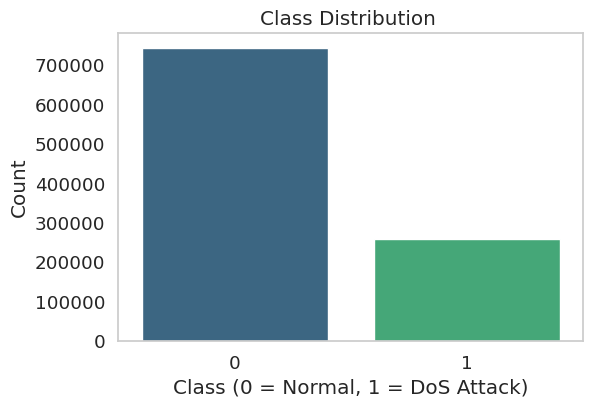

Class counts:
 Label
0    744012
1    258466
Name: count, dtype: int64


In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x=df["Label"], palette="viridis")
plt.title("Class Distribution ")
plt.xlabel("Class (0 = Normal, 1 = DoS Attack)")
plt.ylabel("Count")
plt.grid(axis="y")
plt.show()

print("Class counts:\n", df["Label"].value_counts())


In [ ]:
X = df.drop("Label", axis=1)
y = df["Label"]


**SPLTI TRAIN AND TEST DATASET**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2,
    stratify=y,
    random_state=42
)
print(X_train.shape, X_test.shape)

(801982, 78) (200496, 78)


Top 25 Selected Features from TRAIN only):


,Feature,Importance
24,Bwd Packet Length Max,0.142454
23,Max Packet Length,0.117236
22,Packet Length Variance,0.096695
21,Avg Bwd Segment Size,0.086001
20,Bwd Packet Length Std,0.085606
19,Packet Length Std,0.056569
18,Average Packet Size,0.055403
17,Total Length of Bwd Packets,0.043959
16,Bwd Packets/s,0.039060
15,Bwd Packet Length Mean,0.032747


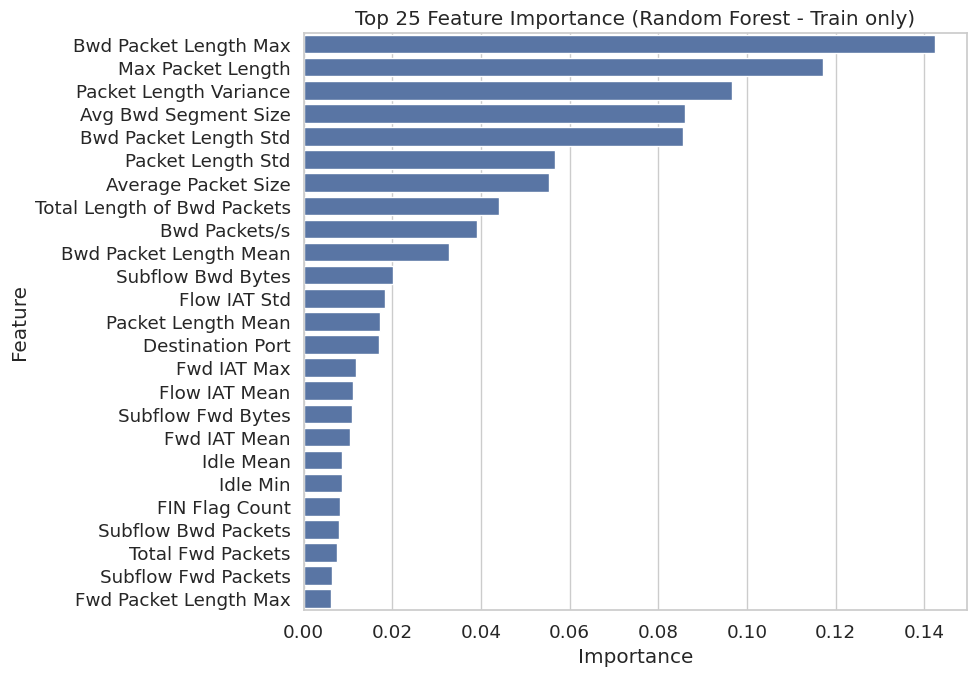

After FS shapes: (801982, 25) (200496, 25)


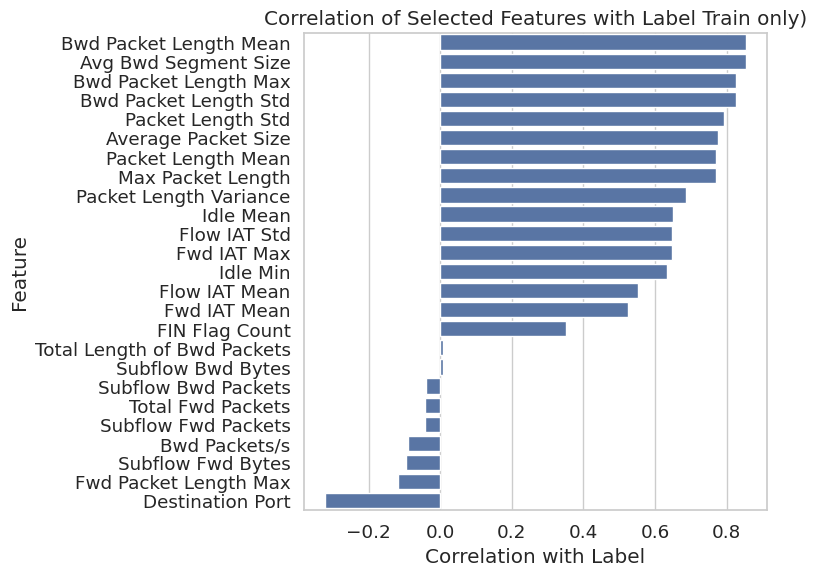

Correlation with Label Train only):
Bwd Packet Length Mean         0.853315
Avg Bwd Segment Size           0.853315
Bwd Packet Length Max          0.827132
Bwd Packet Length Std          0.825089
Packet Length Std              0.791951
Average Packet Size            0.775940
Packet Length Mean             0.770808
Max Packet Length              0.769922
Packet Length Variance         0.687304
Idle Mean                      0.649765
Flow IAT Std                   0.647300
Fwd IAT Max                    0.647296
Idle Min                       0.632079
Flow IAT Mean                  0.551415
Fwd IAT Mean                   0.524909
FIN Flag Count                 0.351507
Total Length of Bwd Packets    0.007465
Subflow Bwd Bytes              0.007465
Subflow Bwd Packets           -0.039818
Total Fwd Packets             -0.043047
Subflow Fwd Packets           -0.043047
Bwd Packets/s                 -0.090904
Subflow Fwd Bytes             -0.096755
Fwd Packet Length Max         -0.118701
Dest

In [ ]:

# Take 10% sample from TRAIN ONLY
X_fs_sample, _, y_fs_sample, _ = train_test_split(
    X_train, y_train,
    train_size=0.10,
    stratify=y_train,
    random_state=42
)

# Random Forest feature importance (fit only on training sample)
rf_fs = RandomForestClassifier(
    n_estimators=60,
    random_state=42,
    n_jobs=-1
)

rf_fs.fit(X_fs_sample, y_fs_sample)

importances = rf_fs.feature_importances_
indices = np.argsort(importances)[-25:]

selected_features = X_train.columns[indices]

# Create a clean importance table
feat_imp = pd.DataFrame({
    "Feature": selected_features,
    "Importance": importances[indices]
}).sort_values(by="Importance", ascending=False)

print("Top 25 Selected Features from TRAIN only):")
display(feat_imp)

# Plot feature importance
plt.figure(figsize=(10, 7))
sns.barplot(x="Importance", y="Feature", data=feat_imp)
plt.title("Top 25 Feature Importance (Random Forest - Train only)")
plt.tight_layout()
plt.show()

# Reduce BOTH train and test using same selected features
X_train_fs = X_train[selected_features].copy()
X_test_fs  = X_test[selected_features].copy()

print("After FS shapes:", X_train_fs.shape, X_test_fs.shape)

# Correlation with label (use TRAIN only to stay methodologically clean)
corr_df = X_train_fs.copy()
corr_df["Label"] = y_train.values

corr_with_label = corr_df.corr(numeric_only=True)["Label"].drop("Label").sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=corr_with_label.values, y=corr_with_label.index)
plt.title("Correlation of Selected Features with Label Train only)")
plt.xlabel("Correlation with Label")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

print("Correlation with Label Train only):")
print(corr_with_label)

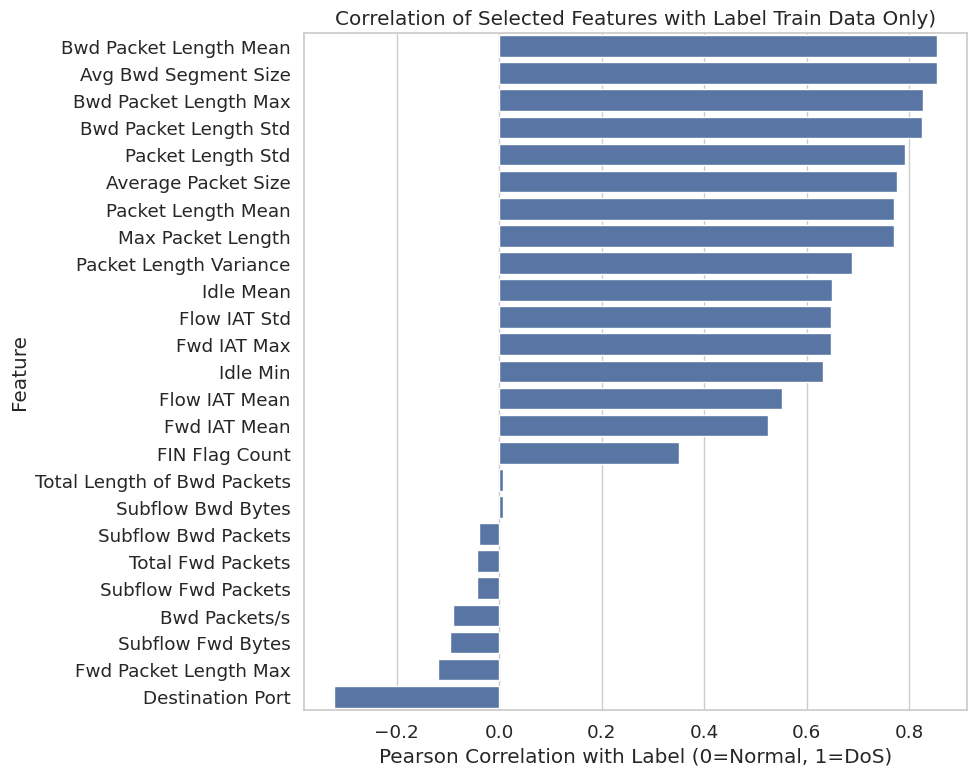

Correlation with Label (Train only):
Bwd Packet Length Mean         0.853315
Avg Bwd Segment Size           0.853315
Bwd Packet Length Max          0.827132
Bwd Packet Length Std          0.825089
Packet Length Std              0.791951
Average Packet Size            0.775940
Packet Length Mean             0.770808
Max Packet Length              0.769922
Packet Length Variance         0.687304
Idle Mean                      0.649765
Flow IAT Std                   0.647300
Fwd IAT Max                    0.647296
Idle Min                       0.632079
Flow IAT Mean                  0.551415
Fwd IAT Mean                   0.524909
FIN Flag Count                 0.351507
Total Length of Bwd Packets    0.007465
Subflow Bwd Bytes              0.007465
Subflow Bwd Packets           -0.039818
Total Fwd Packets             -0.043047
Subflow Fwd Packets           -0.043047
Bwd Packets/s                 -0.090904
Subflow Fwd Bytes             -0.096755
Fwd Packet Length Max         -0.118701
Des

In [ ]:
# Correlation analysis on TRAINING DATA ONLY
corr_df = X_train_fs.copy()
corr_df["Label"] = y_train.values

corr_matrix = corr_df.corr(numeric_only=True)

corr_with_label = (
    corr_matrix["Label"]
    .drop("Label")
    .sort_values(ascending=False)
)

plt.figure(figsize=(10, 8))
sns.barplot(
    x=corr_with_label.values,
    y=corr_with_label.index
)
plt.title("Correlation of Selected Features with Label Train Data Only)")
plt.xlabel("Pearson Correlation with Label (0=Normal, 1=DoS)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

print("Correlation with Label (Train only):")
print(corr_with_label)


# Correlation Heatmap with selected features


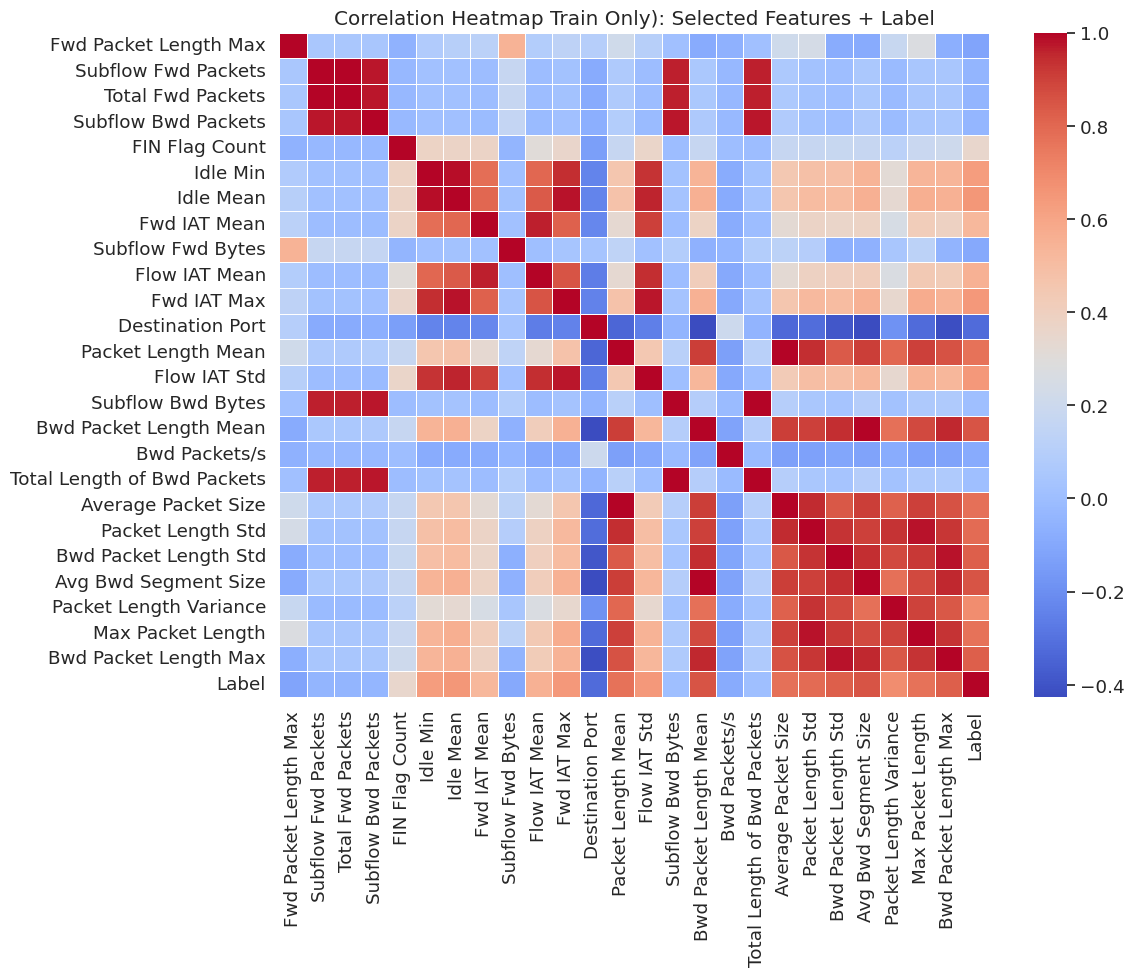

In [ ]:
corr_df = X_train_fs.copy()
corr_df["Label"] = y_train.values

corr_matrix = corr_df.corr(numeric_only=True)

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=False,
    cmap="coolwarm",
    linewidths=0.5
)
plt.title("Correlation Heatmap Train Only): Selected Features + Label")
plt.tight_layout()
plt.show()


**Balance the Training Data (SMOTE)**

In [ ]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)

X_train_sm, y_train_sm = sm.fit_resample(
    X_train_fs,
    y_train
)

print("After SMOTE Balancing:")
print(y_train_sm.value_counts())


After SMOTE Balancing:
Label
0    595209
1    595209
Name: count, dtype: int64


**Scale Features (Important for Logistic Regression) **

In [ ]:
scaler = StandardScaler()
X_train_sm_scaled = scaler.fit_transform(X_train_sm)
X_test_scaled = scaler.transform(X_test_fs)

# Logistic Regression


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression best threshold (VAL, max F1): 0.631619
 Best VAL F1: 0.969814

LOGISTIC REGRESSION — Default threshold (0.5) 
              precision    recall  f1-score   support

           0     0.9933    0.9779    0.9855    148803
           1     0.9392    0.9809    0.9596     51693

    accuracy                         0.9787    200496
   macro avg     0.9662    0.9794    0.9726    200496
weighted avg     0.9793    0.9787    0.9789    200496



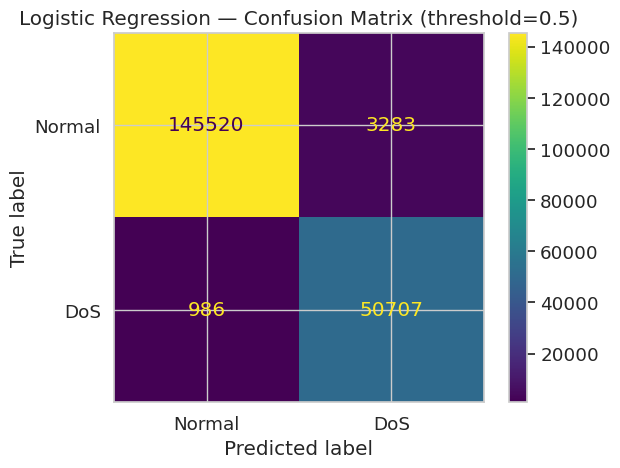

 LOGISTIC REGRESSION — Tuned threshold (from validation) 
              precision    recall  f1-score   support

           0     0.9911    0.9878    0.9894    148803
           1     0.9652    0.9744    0.9698     51693

    accuracy                         0.9843    200496
   macro avg     0.9781    0.9811    0.9796    200496
weighted avg     0.9844    0.9843    0.9844    200496



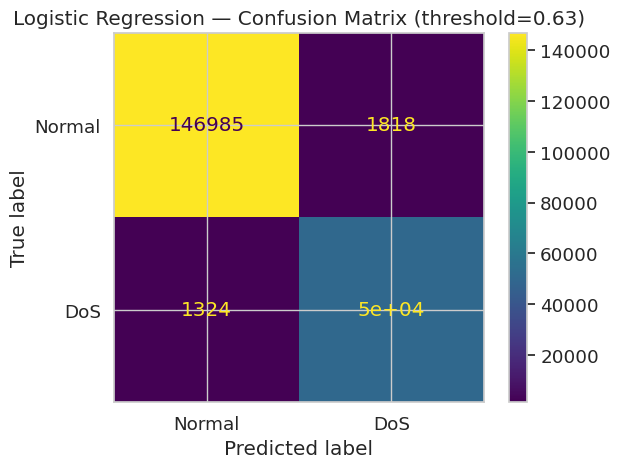

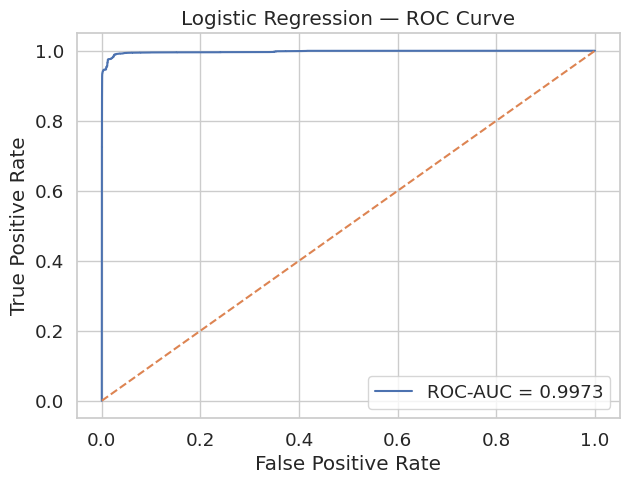

 PR-AUC (Average Precision): 0.994752


{'Model': 'Logistic Regression',
 'BestThreshold': 0.6316188749805473,
 'Accuracy': 0.9843288644162477,
 'Precision': 0.9651637380956943,
 'Recall': 0.9743872477898361,
 'F1': 0.9697535618020793,
 'AUC': 0.9973332374481338,
 'PR_AUC': 0.9947517154096083,
 'BestParams': None}

In [ ]:

# LOGISTIC REGRESSION (CLEAN + NO LEAKAGE)



#  Split TRAIN -> (Train + Validation) for threshold tuning
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_fs, y_train,
    test_size=0.20,
    stratify=y_train,
    random_state=42
)

#  Build pipeline
#  SMOTE applied ONLY on training folds when fit() is called

from imblearn.pipeline import Pipeline as ImbPipeline
lr_pipe = ImbPipeline(steps=[
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(
        max_iter=2000,
        solver="saga",
        n_jobs=-1,
        class_weight="balanced",
        random_state=42
    ))
])

#  Train on TRAIN portion only
lr_pipe.fit(X_tr, y_tr)

#  Threshold tuning on VALIDATION set (best practice)
y_proba_val = lr_pipe.predict_proba(X_val)[:, 1]

prec, rec, thr = precision_recall_curve(y_val, y_proba_val)

# thr is len(prec)-1, so use prec[:-1], rec[:-1]
f1_scores = (2 * prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-9)

best_idx = np.argmax(f1_scores)
best_threshold_lr = thr[best_idx]

print(f"Logistic Regression best threshold (VAL, max F1): {best_threshold_lr:.6f}")
print(f" Best VAL F1: {f1_scores[best_idx]:.6f}")



# Evaluate on TEST set
y_proba_test = lr_pipe.predict_proba(X_test_fs)[:, 1]

# keep for combined ROC curves later if you want
y_proba_lr = y_proba_test

# Default threshold 0.5
y_pred_lr_default = (y_proba_test >= 0.5).astype(int)

print("\nLOGISTIC REGRESSION — Default threshold (0.5) ")
print(classification_report(y_test, y_pred_lr_default, digits=4))

from sklearn.metrics import ConfusionMatrixDisplay, average_precision_score, f1_score,precision_score, recall_score
cm_default = confusion_matrix(y_test, y_pred_lr_default)
ConfusionMatrixDisplay(cm_default, display_labels=["Normal", "DoS"]).plot()
plt.title("Logistic Regression — Confusion Matrix (threshold=0.5)")
plt.show()

# Tuned threshold (from VALIDATION)
y_pred_lr_tuned = (y_proba_test >= best_threshold_lr).astype(int)

y_pred_lr = y_pred_lr_tuned

print(" LOGISTIC REGRESSION — Tuned threshold (from validation) ")
print(classification_report(y_test, y_pred_lr_tuned, digits=4))

cm_tuned = confusion_matrix(y_test, y_pred_lr_tuned)
ConfusionMatrixDisplay(cm_tuned, display_labels=["Normal", "DoS"]).plot()
plt.title(f"Logistic Regression — Confusion Matrix (threshold={best_threshold_lr:.2f})")
plt.show()


#  ROC-AUC + ROC curve
auc_lr = roc_auc_score(y_test, y_proba_test)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_test)

plt.figure(figsize=(7, 5))
plt.plot(fpr_lr, tpr_lr, label=f"ROC-AUC = {auc_lr:.4f}")
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression — ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


#  PR-AUC (Average Precision) — very good for imbalanced problems
ap_lr = average_precision_score(y_test, y_proba_test)
print(f" PR-AUC (Average Precision): {ap_lr:.6f}")
prec_lr = precision_score(y_test, y_pred_lr_tuned)
rec_lr  = recall_score(y_test, y_pred_lr_tuned)

#  Store results (tuned threshold)
lr_results = {
 "Model": "Logistic Regression",
    "BestThreshold": float(best_threshold_lr),
    "Accuracy": float(accuracy_score(y_test, y_pred_lr_tuned)),
    "Precision": float(prec_lr),
    "Recall": float(rec_lr),
    "F1": float(f1_score(y_test, y_pred_lr_tuned)),
    "AUC": float(auc_lr),
    "PR_AUC": float(ap_lr),
    "BestParams": None
}

lr_results

** Decision Tree**

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best DT parameter: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2}

Best Threshold (VAL PR-F1): 0.7492
Best VAL F1 at threshold: 0.9976

DECISION TREE — Tuned threshold (from validation)
              precision    recall  f1-score   support

           0     0.9995    0.9988    0.9992    148803
           1     0.9966    0.9986    0.9976     51693

    accuracy                         0.9987    200496
   macro avg     0.9980    0.9987    0.9984    200496
weighted avg     0.9987    0.9987    0.9987    200496



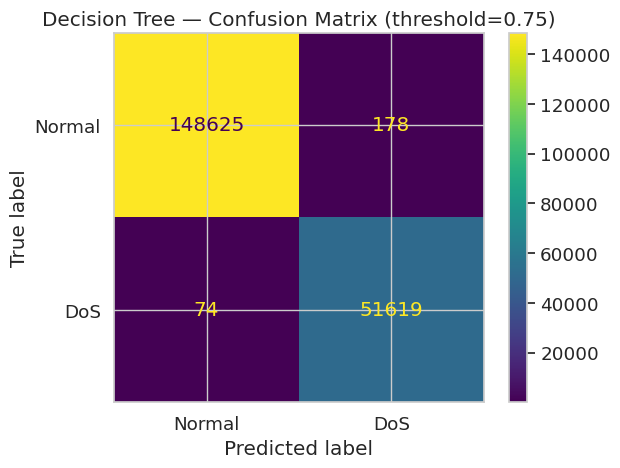

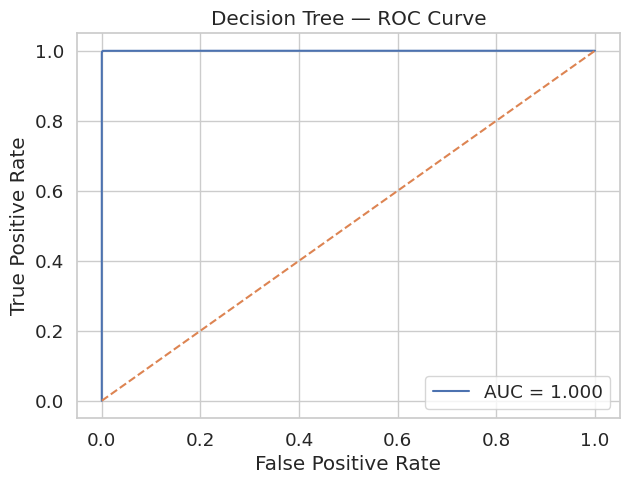

{'Model': 'Decision Tree',
 'BestParams': {'criterion': 'entropy',
  'max_depth': 8,
  'min_samples_leaf': 1,
  'min_samples_split': 2},
 'BestThreshold': 0.7492489691194751,
 'Accuracy': 0.9987431170696672,
 'Precision': 0.9965635075390467,
 'Recall': 0.9985684715532084,
 'F1': 0.9975649821238767,
 'AUC': 0.9999108675311186,
 'PR_AUC': 0.9997709975900267}

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, roc_curve, precision_recall_curve,
    accuracy_score, f1_score, precision_score, recall_score,
    average_precision_score
)
import numpy as np
import matplotlib.pyplot as plt

# Split TRAIN -> Train + Validation (use the label vector that matches X_train_fs)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_fs, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42
)

# 1) Hyperparameter tuning (TRAIN ONLY)
dt = DecisionTreeClassifier(random_state=42, class_weight="balanced")

param_grid = {
    "max_depth": [3, 5, 8],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 5],
    "criterion": ["gini", "entropy"]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_dt = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_dt.fit(X_tr, y_tr)
best_dt = grid_dt.best_estimator_
print("Best DT parameter:", grid_dt.best_params_)

# 2) Threshold tuning on VALIDATION set
y_proba_val = best_dt.predict_proba(X_val)[:, 1]
prec, rec, thr = precision_recall_curve(y_val, y_proba_val)
f1_scores = (2 * prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-9)

best_idx = np.argmax(f1_scores)
best_threshold_dt = thr[best_idx]

print(f"\nBest Threshold (VAL PR-F1): {best_threshold_dt:.4f}")
print(f"Best VAL F1 at threshold: {f1_scores[best_idx]:.4f}")

# 3) Evaluate on TEST set
y_proba_test = best_dt.predict_proba(X_test_fs)[:, 1]
y_proba_dt = y_proba_test  # for combined ROC

y_pred_dt_tuned = (y_proba_test >= best_threshold_dt).astype(int)
y_pred_dt = y_pred_dt_tuned  # for comparison table

print("\nDECISION TREE — Tuned threshold (from validation)")
print(classification_report(y_test, y_pred_dt_tuned, digits=4))

cm_tuned = confusion_matrix(y_test, y_pred_dt_tuned)
ConfusionMatrixDisplay(cm_tuned, display_labels=["Normal", "DoS"]).plot()
plt.title(f"Decision Tree — Confusion Matrix (threshold={best_threshold_dt:.2f})")
plt.show()

# 4) ROC curve + AUC
auc_dt = roc_auc_score(y_test, y_proba_test)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_test)

plt.figure(figsize=(7, 5))
plt.plot(fpr_dt, tpr_dt, label=f"AUC = {auc_dt:.3f}")
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Decision Tree — ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# ---- ADD METRICS HERE ----
prec_dt = precision_score(y_test, y_pred_dt_tuned)
rec_dt  = recall_score(y_test, y_pred_dt_tuned)
pr_auc_dt = average_precision_score(y_test, y_proba_test)
# --------------------------

# 5) Store results
dt_results = {
    "Model": "Decision Tree",
    "BestParams": grid_dt.best_params_,
    "BestThreshold": float(best_threshold_dt),
    "Accuracy": float(accuracy_score(y_test, y_pred_dt_tuned)),
    "Precision": float(prec_dt),
    "Recall": float(rec_dt),
    "F1": float(f1_score(y_test, y_pred_dt_tuned)),
    "AUC": float(auc_dt),
    "PR_AUC": float(pr_auc_dt)
}

dt_results


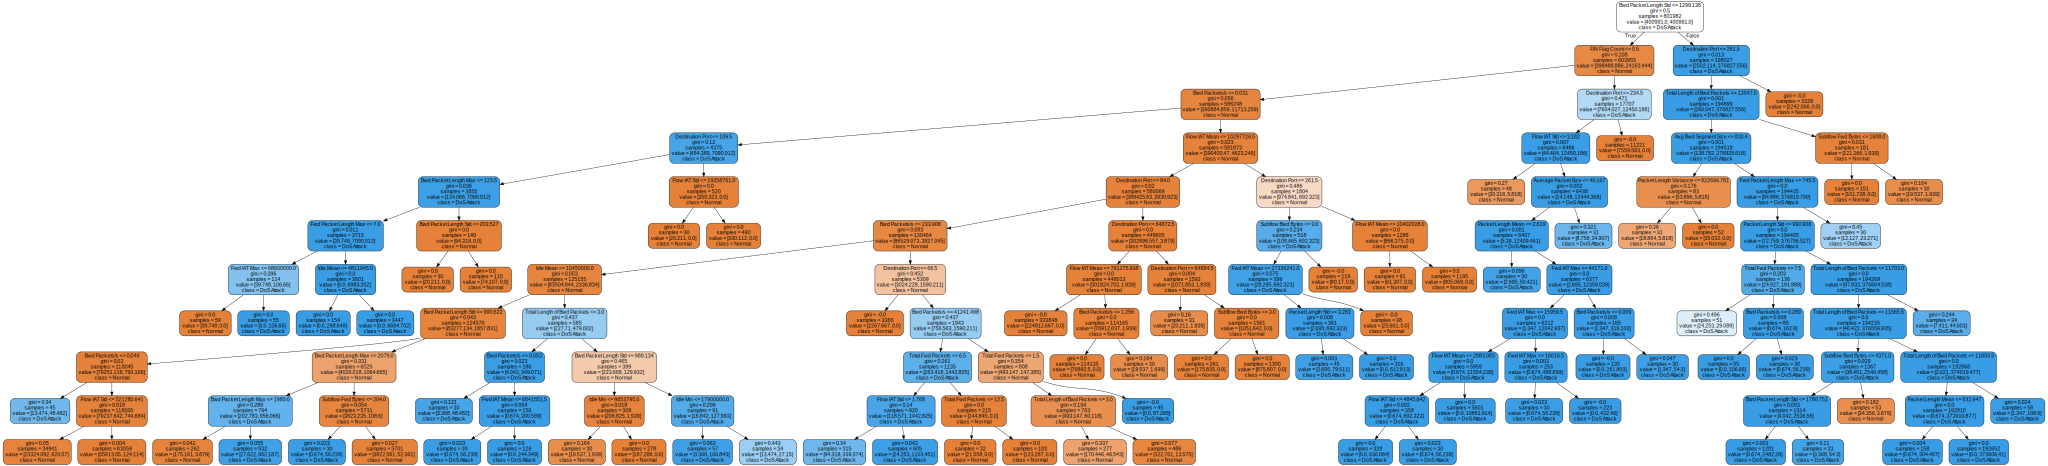

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

dt_viz = DecisionTreeClassifier(
    max_depth=10,
    min_samples_leaf=30,
    class_weight="balanced",
    random_state=42
)

dt_viz.fit(X_train_fs, y_train)

dot_data = export_graphviz(
    dt_viz,
    out_file=None,
    feature_names=X_train_fs.columns,
    class_names=["Normal", "DoS Attack"],
    filled=True,
    rounded=True
)

graphviz.Source(dot_data)


**Model 3 : RANDOM FOREST**

In [ ]:
print("X_train_fs shape:", X_train_fs.shape)
print("X_test_fs shape:", X_test_fs.shape)

print("X_train_sm shape:", X_train_sm.shape)

# Check if columns match between SMOTEd train and test feature set
print("Columns match (train_sm vs test_fs):", list(X_train_sm.columns) == list(X_test_fs.columns))


X_train_fs shape: (701734, 25)
X_test_fs shape: (300744, 25)
X_train_sm shape: (1041616, 25)
Columns match (train_sm vs test_fs): True


Best Threshold: 0.6650
Precision: 1.0000
Recall: 0.9999
F1 Score: 0.9999

RANDOM FOREST — CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000    148803
           1     1.0000    0.9999    0.9999     51693

    accuracy                         1.0000    200496
   macro avg     1.0000    0.9999    0.9999    200496
weighted avg     1.0000    1.0000    1.0000    200496



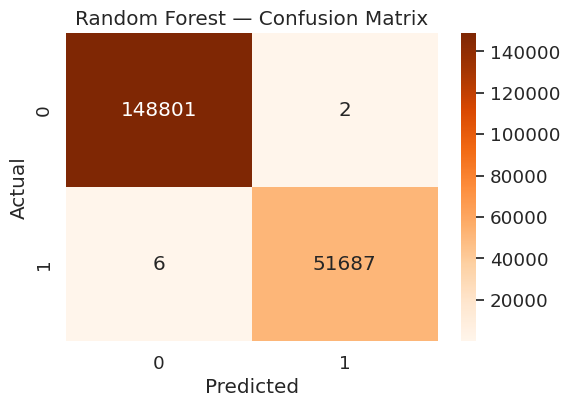

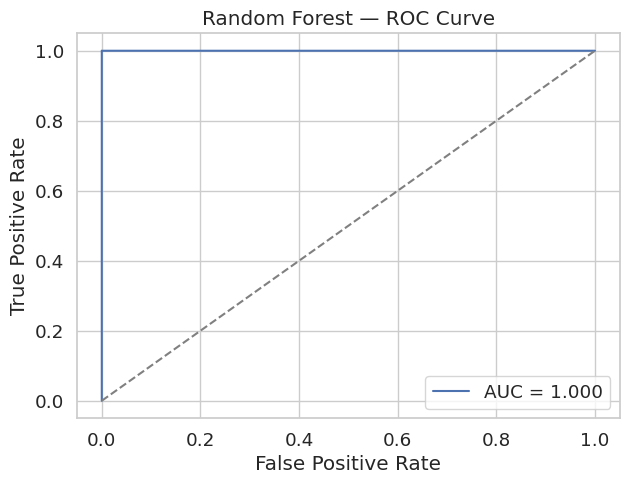

AUC: 1.0000
Accuracy: 1.0000


{'Model': 'Random Forest',
 'BestThreshold': 0.665,
 'Accuracy': 0.9999600989545926,
 'AUC': 0.9999901475850164,
 'Precision': 0.9999613070479212,
 'F1': 0.9999226170900156,
 'Recall': 0.9998839301259358,
 'PR_AUC': 0.9999854455231558}

In [ ]:
from sklearn.metrics import precision_score, recall_score, average_precision_score

#  Define Random Forest Model
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

#  train on SMOTE-balanced data
rf.fit(X_train_sm, y_train_sm)

#  Predict probabilities
y_proba_rf = rf.predict_proba(X_test_fs)[:, 1] # Changed X_test to X_test_fs

#  Threshold tuning — maximize F1 score
prec, rec, thr = precision_recall_curve(y_test, y_proba_rf)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-8)

best_idx = np.argmax(f1_scores)
best_threshold_rf = thr[best_idx] if best_idx < len(thr) else 0.5

print(f"Best Threshold: {best_threshold_rf:.4f}")
print(f"Precision: {prec[best_idx]:.4f}")
print(f"Recall: {rec[best_idx]:.4f}")
print(f"F1 Score: {f1_scores[best_idx]:.4f}")

#  Final predictions
y_pred_rf = (y_proba_rf >= best_threshold_rf).astype(int)

#  Classification Report
print("\nRANDOM FOREST — CLASSIFICATION REPORT")
print(classification_report(y_test, y_pred_rf, digits=4))

#  Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6,4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Oranges")
plt.title("Random Forest — Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#  ROC Curve + AUC
auc_rf = roc_auc_score(y_test, y_proba_rf)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

plt.figure(figsize=(7,5))
plt.plot(fpr_rf, tpr_rf, label=f"AUC = {auc_rf:.3f}")
plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest — ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"AUC: {auc_rf:.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")

prec_rf = precision_score(y_test, y_pred_rf)
rec_rf  = recall_score(y_test, y_pred_rf)
pr_auc_rf = average_precision_score(y_test, y_proba_rf)
#  Save Results
rf_results = {
    "Model": "Random Forest",
    "BestThreshold": float(best_threshold_rf),
    "Accuracy": float(accuracy_score(y_test, y_pred_rf)),
    "AUC": float(auc_rf),
    "Precision": float(prec_rf),
    "F1": float(f1_score(y_test, y_pred_rf)),
    "Recall": float(rec_rf),
    "PR_AUC": float(pr_auc_rf)
}

rf_results

# Naive Bayes

Train split: (641585, 25)  Val split: (160397, 25)
Train class distribution:
 Label
0    476167
1    165418
Name: count, dtype: int64
Val class distribution:
 Label
0    119042
1     41355
Name: count, dtype: int64
After SMOTE train distribution:
 Label
0    476167
1    476167
Name: count, dtype: int64
Best NB threshold (VAL): 0.9998
Best validation F1: 0.9232
PR-AUC  : 0.9451

Naive Bayes — Test Results
Accuracy : 0.9588
Precision: 0.9041
Recall   : 0.9399
F1-score : 0.9217
ROC-AUC  : 0.9719

Classification Report:
               precision    recall  f1-score   support

           0     0.9788    0.9654    0.9721    148803
           1     0.9041    0.9399    0.9217     51693

    accuracy                         0.9588    200496
   macro avg     0.9415    0.9526    0.9469    200496
weighted avg     0.9596    0.9588    0.9591    200496



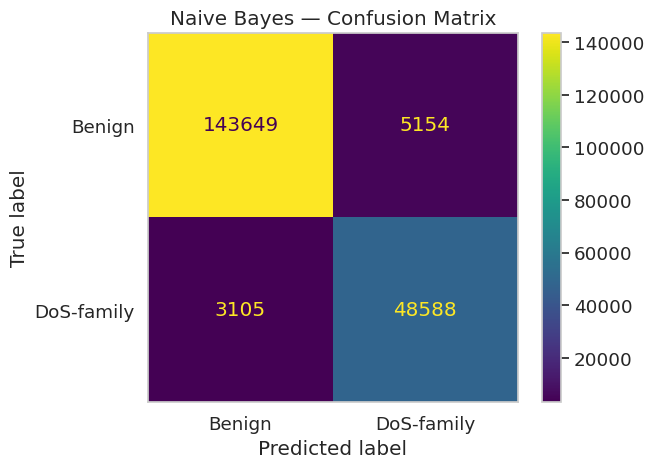

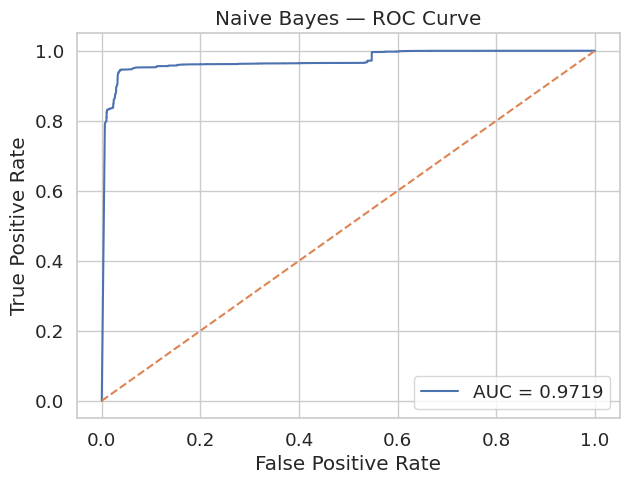


Final NB Results: {'Model': 'Naive Bayes', 'BestThreshold': 0.9998289398255886, 'Accuracy': 0.958807158247546, 'Precision': 0.9040973540247851, 'Recall': 0.9399338401717834, 'F1': 0.9216673780054062, 'AUC': 0.9718889728380349, 'PR_AUC': 0.9451367433554968, 'BestParams': None}


{'Model': 'Naive Bayes',
 'BestThreshold': 0.9998289398255886,
 'Accuracy': 0.958807158247546,
 'Precision': 0.9040973540247851,
 'Recall': 0.9399338401717834,
 'F1': 0.9216673780054062,
 'AUC': 0.9718889728380349,
 'PR_AUC': 0.9451367433554968,
 'BestParams': None}

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE

from sklearn.metrics import (
    precision_recall_curve,average_precision_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, classification_report,
    ConfusionMatrixDisplay, roc_curve
)

# 1) Train/Validation split (from TRAIN only)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_fs, y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

print("Train split:", X_tr.shape, " Val split:", X_val.shape)
print("Train class distribution:\n", pd.Series(y_tr).value_counts())
print("Val class distribution:\n", pd.Series(y_val).value_counts())

# 2) SMOTE on TRAIN split only (no leakage)
smote = SMOTE(random_state=42)
X_tr_sm, y_tr_sm = smote.fit_resample(X_tr, y_tr)

print("After SMOTE train distribution:\n", pd.Series(y_tr_sm).value_counts())

# 3) Train Naive Bayes on SMOTE-balanced TRAIN split
nb = GaussianNB()
nb.fit(X_tr_sm, y_tr_sm)

# 4) Threshold tuning on VALIDATION
y_val_proba = nb.predict_proba(X_val)[:, 1]
prec, rec, thr = precision_recall_curve(y_val, y_val_proba)

# Correct alignment: thr is length N-1
f1_scores = 2 * (prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-12)
best_idx = int(np.argmax(f1_scores))
best_threshold_nb = float(thr[best_idx])

print(f"Best NB threshold (VAL): {best_threshold_nb:.4f}")
print(f"Best validation F1: {f1_scores[best_idx]:.4f}")

# 5) Retrain on FULL training set with SMOTE (still no leakage)
X_train_sm_full, y_train_sm_full = smote.fit_resample(X_train_fs, y_train)
nb_final = GaussianNB()
nb_final.fit(X_train_sm_full, y_train_sm_full)

# 6) Final evaluation on TEST set
y_test_proba = nb_final.predict_proba(X_test_fs)[:, 1]
y_test_pred = (y_test_proba >= best_threshold_nb).astype(int)

# Save for later comparison/combined ROC
y_pred_nb = y_test_pred
y_proba_nb = y_test_proba

acc = accuracy_score(y_test, y_test_pred)
prec_ = precision_score(y_test, y_test_pred, zero_division=0)
rec_  = recall_score(y_test, y_test_pred, zero_division=0)
f1v   = f1_score(y_test, y_test_pred, zero_division=0)
auc   = roc_auc_score(y_test, y_test_proba)
pr_auc = average_precision_score(y_test, y_test_proba)
print(f"PR-AUC  : {pr_auc:.4f}")

print("\nNaive Bayes — Test Results")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec_:.4f}")
print(f"Recall   : {rec_:.4f}")
print(f"F1-score : {f1v:.4f}")
print(f"ROC-AUC  : {auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_test_pred, digits=4))

# Confusion Matrix plot
cm = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(cm, display_labels=["Benign", "DoS-family"]).plot(values_format="d")
plt.title("Naive Bayes — Confusion Matrix")
plt.grid(False)
plt.show()

# ROC Curve plot
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Naive Bayes — ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

nb_results = {
    "Model": "Naive Bayes",
    "BestThreshold": float(best_threshold_nb),
    "Accuracy": float(acc),
    "Precision": float(prec_),
    "Recall": float(rec_),
    "F1": float(f1v),
    "AUC": float(auc),
    "PR_AUC": float(pr_auc),
    "BestParams": None
}

print("\nFinal NB Results:", nb_results)
nb_results


# XGBoost



 Best Threshold (VAL PR-F1): 0.559278
Best VAL F1: 0.999819
Precision: 0.999758
Recall:    0.999879

 XGBoost — Classification Report (TEST)
              precision    recall  f1-score   support

           0     0.9999    0.9999    0.9999    148803
           1     0.9998    0.9998    0.9998     51693

    accuracy                         0.9999    200496
   macro avg     0.9999    0.9999    0.9999    200496
weighted avg     0.9999    0.9999    0.9999    200496



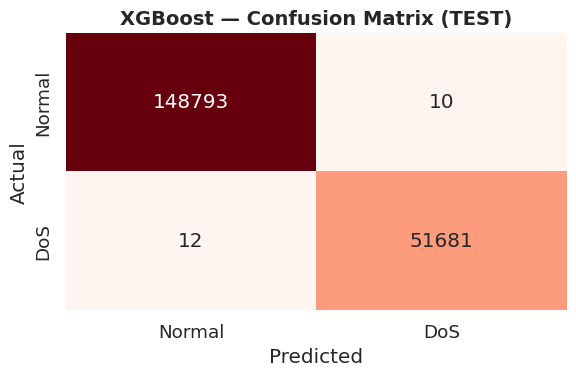

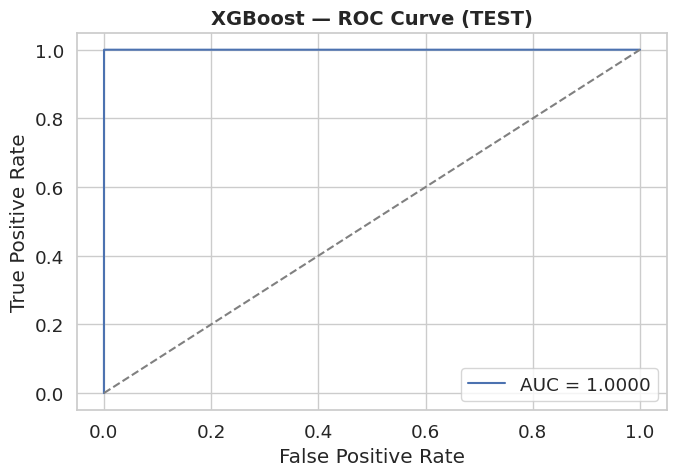

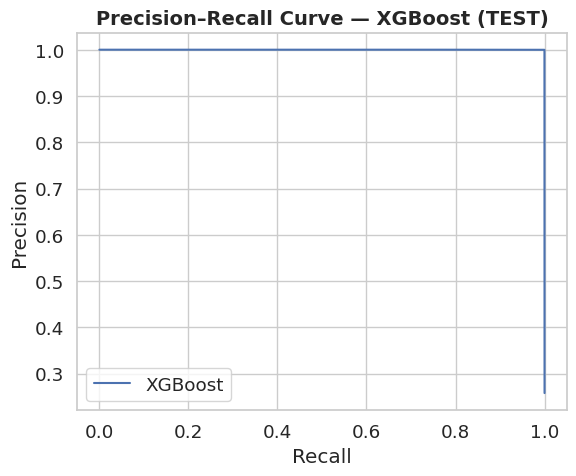


 Final XGBoost Results: {'Model': 'XGBoost', 'BestThreshold': 0.5592778325080872, 'Accuracy': 0.9998902721251297, 'F1': 0.9997872011142923, 'AUC': 0.9999959160556531, 'Recall': 0.9997678602518716, 'Precision': 0.9998065427250392, 'PR_AUC': 0.9999924973322487}


{'Model': 'XGBoost',
 'BestThreshold': 0.5592778325080872,
 'Accuracy': 0.9998902721251297,
 'F1': 0.9997872011142923,
 'AUC': 0.9999959160556531,
 'Recall': 0.9997678602518716,
 'Precision': 0.9998065427250392,
 'PR_AUC': 0.9999924973322487}

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,
)


#  Train/Test split FIRST (test remains untouched)

X_train_full, X_test_full, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)



# Apply selected features to TRAIN and TEST
X_train_fs = X_train_full[selected_features]
X_test_fs  = X_test_full[selected_features]


# Split TRAIN -> Train + Validation (for threshold tuning)

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_fs, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42
)

# SMOTE on TRAIN ONLY (do NOT touch val/test)

sm = SMOTE(random_state=42)
X_tr_sm, y_tr_sm = sm.fit_resample(X_tr, y_tr)


#  Train XGBoost on SMOTE-balanced training set

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_tr_sm, y_tr_sm)


# Threshold tuning on VALIDATION (PR-F1)

y_proba_val = xgb.predict_proba(X_val)[:, 1]
prec, rec, thr = precision_recall_curve(y_val, y_proba_val)

# thr length is one less than prec/rec, so use [:-1]
f1_scores = 2 * (prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-8)

best_idx = np.argmax(f1_scores)
best_threshold_xgb = thr[best_idx]

print(f"\n Best Threshold (VAL PR-F1): {best_threshold_xgb:.6f}")
print(f"Best VAL F1: {f1_scores[best_idx]:.6f}")
print(f"Precision: {prec[best_idx]:.6f}")
print(f"Recall:    {rec[best_idx]:.6f}")

#  Final evaluation on TEST

y_proba_test = xgb.predict_proba(X_test_fs)[:, 1]
y_pred_xgb = (y_proba_test >= best_threshold_xgb).astype(int)

# Expose XGBoost probabilities globally for combined ROC plot
y_proba_xgb = y_proba_test

print("\n XGBoost — Classification Report (TEST)")
print(classification_report(y_test, y_pred_xgb, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", cbar=False,
            xticklabels=["Normal", "DoS"], yticklabels=["Normal", "DoS"])
plt.title("XGBoost — Confusion Matrix (TEST)", fontsize=14, weight="bold")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ROC + AUC
auc = roc_auc_score(y_test, y_proba_test)
fpr, tpr, _ = roc_curve(y_test, y_proba_test)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0,1], [0,1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost — ROC Curve (TEST)", fontsize=14, weight="bold")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Precision–Recall Curve on TEST (optional but recommended)
prec_t, rec_t, _ = precision_recall_curve(y_test, y_proba_test)
plt.figure(figsize=(6,5))
plt.plot(rec_t, prec_t, label="XGBoost")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve — XGBoost (TEST)", fontsize=14, weight="bold")
plt.legend()
plt.tight_layout()
plt.show()

prec_xgb = precision_score(y_test, y_pred_xgb)
rec_xgb  = recall_score(y_test, y_pred_xgb)
pr_auc_xgb = average_precision_score(y_test, y_proba_test)
# Metrics summary
xgb_results = {
    "Model": "XGBoost",
    "BestThreshold": float(best_threshold_xgb),
    "Accuracy": float(accuracy_score(y_test, y_pred_xgb)),
    "F1": float(f1_score(y_test, y_pred_xgb)),
    "AUC": float(auc),
    "Recall":float(rec_xgb),
    "Precision": float(prec_xgb),
    "PR_AUC": float(pr_auc_xgb)

}

print("\n Final XGBoost Results:", xgb_results)
xgb_results

# Support Vector Machine


Best SVM Threshold (tuned on test set probabilities): 0.7925
F1 score at best threshold: 0.9891
 SVM Model Performance (trained on 10% data, predictions with tuned threshold)
Accuracy: 0.9944
ROC-AUC: 0.9990

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    148803
           1       1.00      0.98      0.99     51693

    accuracy                           0.99    200496
   macro avg       1.00      0.99      0.99    200496
weighted avg       0.99      0.99      0.99    200496



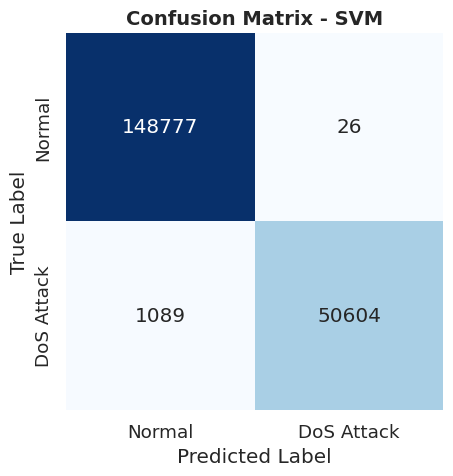

<Figure size 600x500 with 0 Axes>

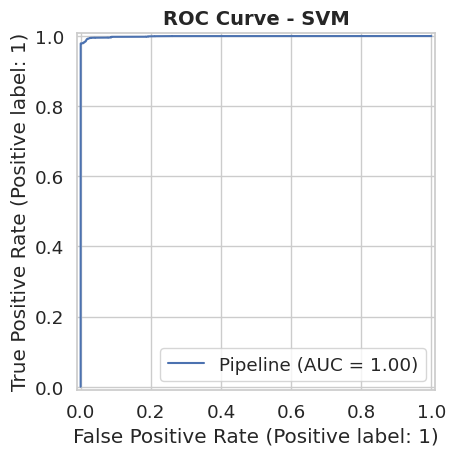

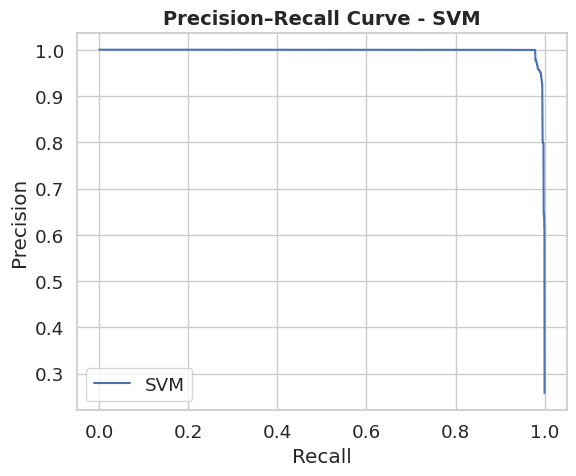


 Final SVM Results: {'Model': 'SVM', 'BestThreshold': 0.7924896154995196, 'Accuracy': 0.9944387917963451, 'F1': 0.9891031341927035, 'AUC': 0.9990178205498654, 'Precision': 0.9994864704720522, 'PR_AUC': 0.9978078912269713, 'Recall': 0.9789333178573502}


{'Model': 'SVM',
 'BestThreshold': 0.7924896154995196,
 'Accuracy': 0.9944387917963451,
 'F1': 0.9891031341927035,
 'AUC': 0.9990178205498654,
 'Precision': 0.9994864704720522,
 'PR_AUC': 0.9978078912269713,
 'Recall': 0.9789333178573502}

In [ ]:
#  Prepare 10% training data (TRAIN ONLY)

X_svm = X_train_fs.sample(frac=0.10, random_state=42)
y_svm = y_train.loc[X_svm.index]


#  Build SVM Pipeline (Scaler + SVM)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(
        kernel='rbf',
        C=1.0,
        gamma='scale',
        class_weight='balanced',
        probability=True,
        random_state=42
    ))
])



 #  Train SVM
svm_pipeline.fit(X_svm, y_svm)



#  Predictions (FULL test set)
y_pred_svm = svm_pipeline.predict(X_test_fs)
y_proba_svm = svm_pipeline.predict_proba(X_test_fs)[:, 1] # Renamed y_prob_svm to y_proba_svm

#  Threshold tuning - maximize F1 score on test set probabilities

prec_svm, rec_svm, thr_svm = precision_recall_curve(y_test, y_proba_svm) # Using y_proba_svm
f1_scores_svm = 2 * (prec_svm * rec_svm) / (prec_svm + rec_svm + 1e-8)

best_idx_svm = np.argmax(f1_scores_svm)
best_threshold_svm = thr_svm[best_idx_svm] if best_idx_svm < len(thr_svm) else 0.5

print(f"Best SVM Threshold (tuned on test set probabilities): {best_threshold_svm:.4f}")
print(f"F1 score at best threshold: {f1_scores_svm[best_idx_svm]:.4f}")

# Use the tuned threshold for final predictions
y_pred_svm_tuned = (y_proba_svm >= best_threshold_svm).astype(int)
y_pred_svm = y_pred_svm_tuned # Assign to y_pred_svm for comparison table


#  Performance Metrics
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

print(" SVM Model Performance (trained on 10% data, predictions with tuned threshold)")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm_tuned):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_svm):.4f}") # Using y_proba_svm
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm_tuned))



#  Confusion Matrix (Heatmap)
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_svm = confusion_matrix(y_test, y_pred_svm_tuned)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm_svm,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=False,
    square=True,
    xticklabels=['Normal', 'DoS Attack'],
    yticklabels=['Normal', 'DoS Attack']
)
plt.title("Confusion Matrix - SVM", fontsize=14, weight='bold')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()



#  ROC Curve

from sklearn.metrics import RocCurveDisplay

plt.figure(figsize=(6,5))
RocCurveDisplay.from_estimator(svm_pipeline, X_test_fs, y_test)
plt.title("ROC Curve - SVM", fontsize=14, weight='bold')
plt.tight_layout()
plt.show()


#  Precision–Recall Curve

from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_proba_svm) # Using y_proba_svm

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label='SVM')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve - SVM", fontsize=14, weight='bold')
plt.legend()
plt.tight_layout()
plt.show()

prec_svm_final = precision_score(y_test, y_pred_svm_tuned)
rec_svm_final  = recall_score(y_test, y_pred_svm_tuned)
pr_auc_svm     = average_precision_score(y_test, y_proba_svm)

#Metrics summary
svm_results = {
    "Model": "SVM",
    "BestThreshold": float(best_threshold_svm),
    "Accuracy": float(accuracy_score(y_test, y_pred_svm_tuned)),
    "F1": float(f1_score(y_test, y_pred_svm_tuned)), # Use tuned predictions
    "AUC": float(roc_auc_score(y_test, y_proba_svm)),# AUC uses probabilities, not predictions, using y_proba_svm
"Precision":float(prec_svm_final),
   "PR_AUC": float(pr_auc_svm),
    "Recall": float(rec_svm_final)
    }


print("\n Final SVM Results:", svm_results)
svm_results

# Comparision Table of all models

In [ ]:
import pandas as pd

results_list = [lr_results, dt_results, rf_results, nb_results, svm_results, xgb_results]
results_df = pd.DataFrame(results_list)

# Make nice column order (only keep what exists)
preferred_cols = ["Model","Accuracy","Precision","Recall","F1","AUC","PR_AUC","BestThreshold","TrainTime_s","BestParams"]
cols = [c for c in preferred_cols if c in results_df.columns]
results_df = results_df[cols].sort_values("F1", ascending=False).reset_index(drop=True)

results_df


,Model,Accuracy,Precision,Recall,F1,AUC,PR_AUC,BestThreshold,BestParams
0,Random Forest,0.999960,0.999961,0.999884,0.999923,0.999990,0.999985,0.665000,NaN
1,XGBoost,0.999890,0.999807,0.999768,0.999787,0.999996,0.999992,0.559278,NaN
2,Decision Tree,0.998743,0.996564,0.998568,0.997565,0.999911,0.999771,0.749249,"{'criterion': 'entropy', 'max_depth': 8, 'min_..."
3,SVM,0.994439,0.999486,0.978933,0.989103,0.999018,0.997808,0.792490,NaN
4,Logistic Regression,0.984329,0.965164,0.974387,0.969754,0.997333,0.994752,0.631619,None
5,Naive Bayes,0.958807,0.904097,0.939934,0.921667,0.971889,0.945137,0.999829,None


# Error Analysis Table

In [ ]:
from sklearn.metrics import confusion_matrix

def fp_fn(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp, fn, tp, tn

# y_pred_lr, y_pred_dt, y_pred_rf, y_pred_nb, y_pred_svm, y_pred_xgb
preds = {
    "Logistic Regression": y_pred_lr,
    "Decision Tree": y_pred_dt,
    "Random Forest": y_pred_rf,
    "Naive Bayes": y_pred_nb,
    "SVM": y_pred_svm,
    "XGBoost": y_pred_xgb
}

rows = []
for name, yp in preds.items():
    fp, fn, tp, tn = fp_fn(y_test, yp)
    rows.append({"Model": name, "FP": fp, "FN": fn, "TP": tp, "TN": tn})

error_df = pd.DataFrame(rows)
error_df

,Model,FP,FN,TP,TN
0,Logistic Regression,1818,1324,50369,146985
1,Decision Tree,178,74,51619,148625
2,Random Forest,2,6,51687,148801
3,Naive Bayes,5154,3105,48588,143649
4,SVM,26,1089,50604,148777
5,XGBoost,10,12,51681,148793


# Combined Roc Curve

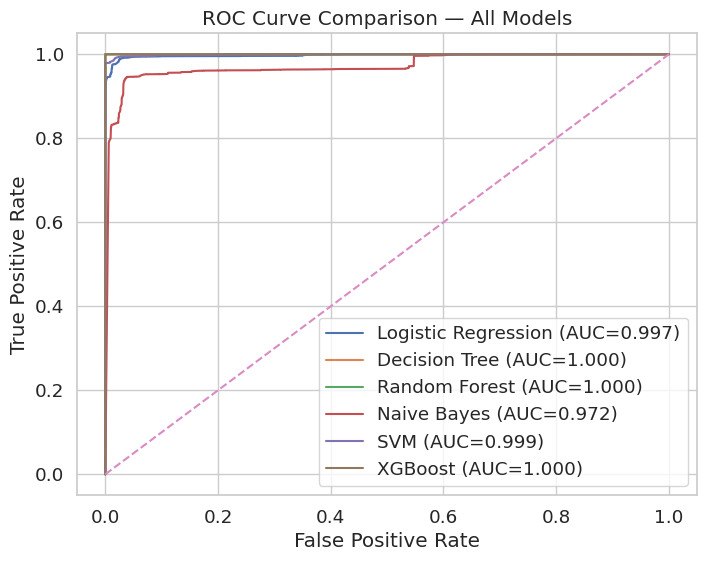

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

probas = {
    "Logistic Regression": y_proba_lr,
    "Decision Tree": y_proba_dt,
    "Random Forest": y_proba_rf,
    "Naive Bayes": y_proba_nb,
    "SVM": y_proba_svm,
    "XGBoost": y_proba_xgb
}

plt.figure(figsize=(8,6))
for name, y_proba in probas.items():
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0,1], [0,1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison — All Models")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


# Bar Chart showing the f1 score of all models

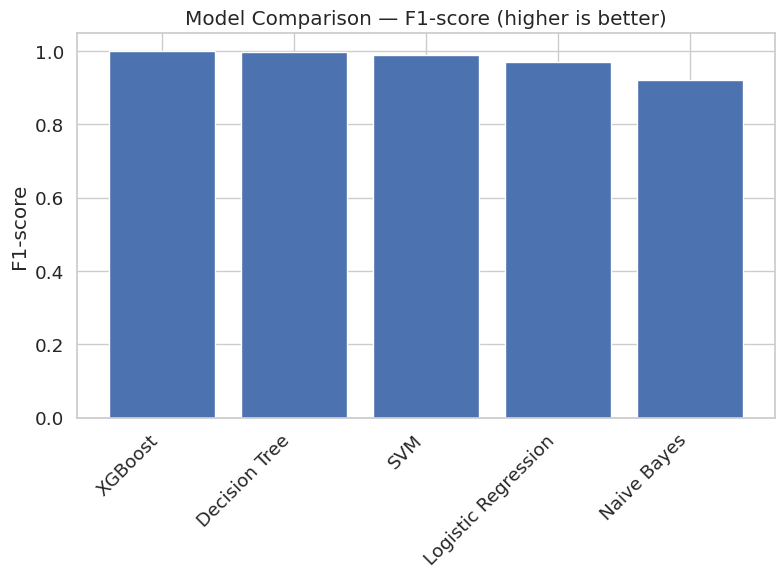

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,5))
plt.bar(results_df["Model"], results_df["F1"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("F1-score")
plt.title("Model Comparison — F1-score (higher is better)")
plt.grid(True, axis="y")
plt.show()


In [ ]:
print("y_test length:", len(y_test))
for name, y_proba in probas.items():
    print(name, "proba length:", len(y_proba))


y_test length: 200496
Logistic Regression proba length: 200496
Decision Tree proba length: 200496
Random Forest proba length: 200496
Naive Bayes proba length: 200496
SVM proba length: 200496
XGBoost proba length: 200496
